In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
sys.path.insert(0, '../')
from species_classification_scripts.individual_stands_classification import Generator

### Check some distribution

In [3]:
for sp_class in ['conifer', 'decidious']:
    pix_num = 0
    for img_ind in range(2): 
        imgpath = '/home/user/data/projects/research-project/notebooks/Illarionova/Forestry_inventory/wv_inference/krasnoborsk/{}_{}.tif'.format(img_ind, sp_class)
        with rasterio.open(imgpath) as src:
            mask = src.read(1)
        pix_num += np.sum(mask)
    print(sp_class, pix_num)

conifer 2069467.0
decidious 3282717.0


### Set generator

In [4]:
class_0=['conifer']
class_1=['decidious']
folders = ['/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/',
           '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/',
           '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A010986_20170730T082009/',
           '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A013017_20190903T081606/',
           '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A015748_20180628T082602/',
           '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A016606_20180827T083208/']
num_channels = 10
batch_size = 64

generator = Generator(batch_size=batch_size,class_0=class_0,class_1=class_1,
                      num_channels=num_channels)
generator.IMG_ROW = 64
generator.IMG_COL = 64
generator.sentinel = True
generator.channels_name = ['B02_10m_norm','B03_10m_norm','B04_10m_norm','B05_10m_norm','B06_10m_norm',
                           'B07_10m_norm','B08_10m_norm','B11_10m_norm','B12_10m_norm','B8A_10m_norm']
weights_list = [ 1., 1.]
loss =  generator.weighted_categorical_crossentropy(weights_list)  

generator.val_region = True
generator.load_dataset(folders)

### Check generated output

In [5]:
len(generator.json_file_linden_val.keys()), len(generator.json_file_linden_train.keys())

(666, 6408)

In [6]:
len(generator.json_file_oak_val.keys()), len(generator.json_file_oak_train.keys())

(1032, 11544)

In [7]:
for img, mask in generator.train_gen():
    break

In [8]:
img.shape, mask.shape

((64, 64, 64, 10), (64, 64, 64, 2))

Text(0.5,1,'class_1')

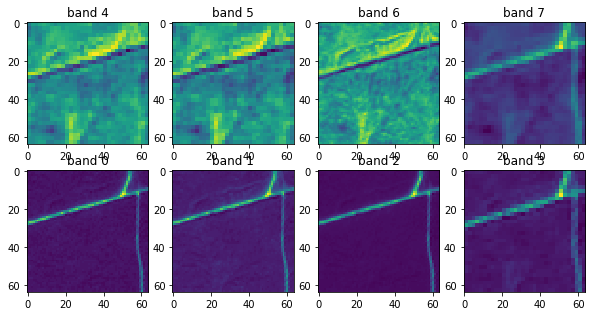

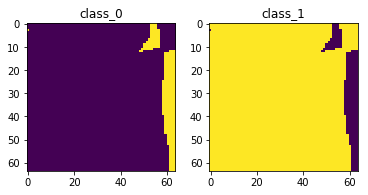

In [9]:
fig = plt.figure(figsize = (10,10))
for i in range(4):
    a = fig.add_subplot(1, 4, i+1)
    imgplot = plt.imshow(img[0, :,:,i])
    a.set_title('band '+str(i))

for i in range(4):
    a = fig.add_subplot(2, 4, i+1)
    imgplot = plt.imshow(img[0, :,:,4+i])
    a.set_title('band '+str(i+4))

fig = plt.figure(figsize = (6,6))
a = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(mask[0, :,:,0])
a.set_title('class_0')
a = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(mask[0, :,:,1])
a.set_title('class_1')

##  Set model

In [10]:
model = Unet(backbone_name='resnet34', input_shape=(None, None, num_channels), classes=2,
                  encoder_weights=None, activation='softmax')
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.callbacks import Callback

In [12]:
model_name = 'multispectral_sentinel'
save_dir = '/home/user/data/example/data/Forestry_inventory/usgs_species_classification/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=5,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [13]:
history=model.fit_generator(generator.train_gen(),epochs=15, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/15
200/200 [==============================] - 305s 2s/step - loss: 0.4478 - loss_1: 0.4478 - val_loss: 0.6385 - val_loss_1: 0.6385

Epoch 00001: val_loss improved from inf to 0.63853, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_sentinel.h5

Epoch 00001: val_loss improved from inf to 0.63853, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_sentinel.hdf5
Epoch 2/15
200/200 [==============================] - 289s 1s/step - loss: 0.3959 - loss_1: 0.3959 - val_loss: 0.6291 - val_loss_1: 0.6291

Epoch 00002: val_loss improved from 0.63853 to 0.62912, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_sentinel.h5

Epoch 00002: val_loss improved from 0.63853 to 0.62912, saving model to /home/user/data/example/data/Forestry_inventory/usgs_species_classification/multispectral_sentinel.hdf5
Epoch 3/15
200/200 [======

In [58]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [76]:
# serialize model to JSON without height
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [14]:
json_file = open(save_dir+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(save_dir+"{}.h5".format(model_name)) 

### Check intersection between train and val samples

In [47]:
samples_val = []
for key in generator.json_file_linden_val.keys():
    sample = generator.json_file_linden_val[key]
    samples_val.append([key.split('_')[0], sample['upper_left_x'], sample['upper_left_y'], sample['pol_width'], sample['pol_height']])
    
samples_train = []
for key in generator.json_file_linden_train.keys():
    sample = generator.json_file_linden_train[key]
    samples_train.append([key.split('_')[0], sample['upper_left_x'], sample['upper_left_y'], sample['pol_width'], sample['pol_height']])

In [48]:
len(set(tuple(i) for i in samples_val+samples_train)) 

1179

In [49]:
k = 0
for sample in samples_val:
    if sample in samples_train:
        k += 1
k

0

## write geojson for validation

In [41]:
import tifffile as tiff
import numpy as np
import rasterio
import matplotlib
import matplotlib.pyplot as plt

import geojson
from rasterio.mask import mask
from osgeo import gdal, osr
from rasterio.plot import plotting_extent

from rasterio import features
from shapely import geometry
from shapely.geometry import Polygon, MultiPolygon

import pandas as pd
import json
import re
import subprocess
from os import listdir
from pyproj import Proj, transform

import scipy
import cv2
from glob import glob

In [39]:
for item in generator.json_file_linden_val.items():
    print(item)

('/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/_989', {'upper_left_x': 2648, 'upper_left_y': 321, 'pol_width': 43, 'pol_height': 30, 'pix_area': 31382.749624902604})
('/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/_37', {'upper_left_x': 3954, 'upper_left_y': 451, 'pol_width': 28, 'pol_height': 16, 'pix_area': 22300.564683288983})
('/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/_749', {'upper_left_x': 2634, 'upper_left_y': 0, 'pol_width': 35, 'pol_height': 21, 'pix_area': 48116.84021816872})
('/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/_213', {'upper_left_x': 3736, 'upper_left_y': 622, 'pol_width': 15, 'pol_height': 7, 'pix_area'

In [43]:
item[1]

{'upper_left_x': 1565,
 'upper_left_y': 2491,
 'pol_width': 190,
 'pol_height': 248,
 'pix_area': 9.251986169194786e-06}

In [ ]:
upper_left_x + pol_width, upper_left_y - pol_height

In [218]:
from shapely.geometry import box
print(box(upper_left_x, upper_left_y, upper_left_x + pol_width, upper_left_y - pol_height))

POLYGON ((2570 904, 2570 889, 2556 889, 2556 904, 2570 904))


In [234]:
from shapely.geometry import Polygon, mapping
mapping(sh_polygon)

In [244]:
from shapely.geometry import Polygon, mapping

extention_list = []
for item in generator.json_file_linden_val.items():
    geom = box(upper_left_x, upper_left_y, upper_left_x + pol_width, upper_left_y - pol_height)
    geom = mapping(geom)['coordinates']
    extention_list.append({'geometry':{'type': 'Polygon', 
                                                'coordinates':geom}})

crs = {
        "type": "name",
        "properties": {
            "name": "EPSG:32639"
        }
    }      
feature_collection = geojson.FeatureCollection(extention_list, crs=crs)
geojson_file = 'validation_linden.geojson'.format(folder, folder)
with open(geojson_file, 'w') as f:
    geojson.dump(feature_collection, f)

In [245]:
feature_collection

{"crs": {"properties": {"name": "EPSG:32639"}, "type": "name"}, "features": [{"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0, 904.0], [2570.0, 904.0]]], "type": "Polygon"}}, {"geometry": {"coordinates": [[[2570.0, 904.0], [2570.0, 889.0], [2556.0, 889.0], [2556.0

In [243]:
extention_list = []
for item in generator.json_file_oak_val.items():
    geom = box(upper_left_x, upper_left_y, upper_left_x + pol_width, upper_left_y - pol_height)
    geom = mapping(geom)['coordinates']
    extention_list.append(geom)

crs = {
        "type": "name",
        "properties": {
            "name": "EPSG:32639"
        }
    }      
feature_collection = geojson.FeatureCollection(extention_list, crs=crs)
geojson_file = 'validation_oak.geojson'.format(folder, folder)
with open(geojson_file, 'w') as f:
    geojson.dump(feature_collection, f)

## All val predict

In [23]:
generator.json_file_linden_val

{'/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/_989': {'upper_left_x': 2648,
  'upper_left_y': 321,
  'pol_width': 43,
  'pol_height': 30,
  'pix_area': 31382.749624902604},
 '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/_37': {'upper_left_x': 3954,
  'upper_left_y': 451,
  'pol_width': 28,
  'pol_height': 16,
  'pix_area': 22300.564683288983},
 '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/_749': {'upper_left_x': 2634,
  'upper_left_y': 0,
  'pol_width': 35,
  'pol_height': 21,
  'pix_area': 48116.84021816872},
 '/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A005695_20160725T082012/_213': {'upper_left_x': 3736,
  'upper_left_y': 622,
  'pol_width': 15,

In [17]:
def pred_val(cl_json):
    imgarr=[]
    maskarr=[]
    for key in cl_json.keys():
        imgpath = key#"_".join(key.split('_')[:-1])
        #print(imgpath)
        upper_left_x, upper_left_y, pol_width, pol_height = cl_json[key]['upper_left_x'], cl_json[key]['upper_left_y'],\
                                                            cl_json[key]['pol_width'], cl_json[key]['pol_height']
        img, mask = generator.get_img_mask_array(imgpath, upper_left_x, upper_left_y, pol_width, pol_height)
        imgarr.append(img)
        maskarr.append(mask)

    imgarr = np.asarray(imgarr)
    maskarr = np.asarray(maskarr)
    return imgarr, maskarr

img_linden, mask_linden = pred_val(generator.json_file_linden_val)
img_oak, mask_oak = pred_val(generator.json_file_oak_val)
pred_linden = model.predict(img_linden)
pred_oak = model.predict(img_oak)

In [55]:
len(generator.json_file_linden_train.keys())

1068

In [31]:
pred_linden.shape, pred_oak.shape, mask_oak.shape

((365, 128, 128, 2), (625, 128, 128, 2), (625, 128, 128, 2))

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f7897cfd2b0>)

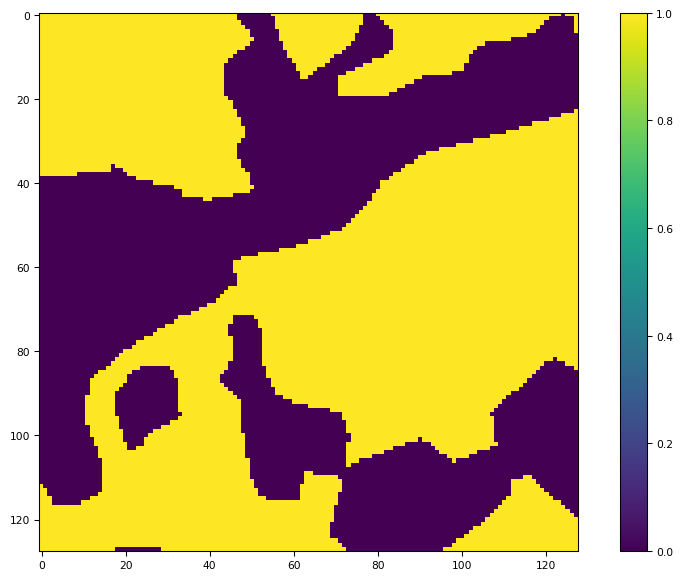

In [32]:
tiff.imshow(mask_oak[ind,:,:,1])

Text(0.5,1,'mask')

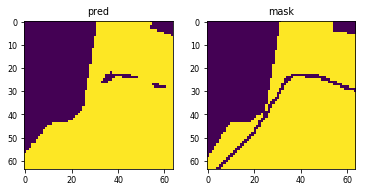

In [53]:
ind = 67
cl_ind = 0
fig = plt.figure(figsize = (6,6))
a = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow((pred_oak[ind,:,:,cl_ind]>0.5)*np.sum(mask_oak[ind],axis=-1))
a.set_title('pred')
a = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(mask_oak[ind,:,:,cl_ind])
a.set_title('mask')

In [36]:
correct_samples = 0
wrong_samples = 0
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1
        
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1

print(correct_samples / (correct_samples + wrong_samples))

0.8725868725868726


In [37]:
correct_samples = 0
wrong_samples = 0
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1
        
print(correct_samples / (correct_samples + wrong_samples))

0.8741830065359477


In [38]:
correct_samples = 0
wrong_samples = 0
        
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        correct_samples += 1
    else:
        wrong_samples += 1

print(correct_samples / (correct_samples + wrong_samples))

0.8702830188679245


## F1

In [18]:
TP = 0
FP = 0
TN = 0
FN = 0
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        TP += 1
    else:
        FN += 1
        
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        TN += 1
    else:
        FP += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN) 
f1_cl = 2*((precision*recall)/(precision+recall))

f1_cl, accuracy

(0.8693790149892935, 0.892226148409894)

In [19]:
TP = 0
FP = 0
TN = 0
FN = 0
for ind in range(img_linden.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_linden[ind,:,:,1]>0.5)*mask_linden[ind,:,:,1]) > np.sum(mask_linden[ind,:,:,1])*0.5:
        TN += 1
    else:
        FP += 1
        
for ind in range(img_oak.shape[0]): # class 0 oak, class 1 linden
    if np.sum((pred_oak[ind,:,:,0]>0.5)*mask_oak[ind,:,:,0]) > np.sum(mask_oak[ind,:,:,0])*0.5:
        TP += 1
    else:
        FN += 1

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN) 
f1_cl = 2*((precision*recall)/(precision+recall))

f1_cl, accuracy

(0.9082706766917292, 0.892226148409894)

***
***

# Evaluation

In [18]:
for img, mask in generator.val_gen():
    break
pred = model.predict(img)

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


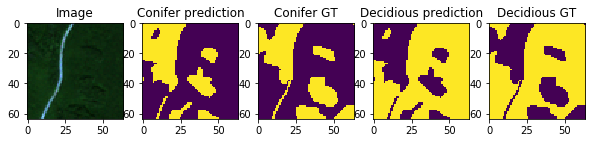

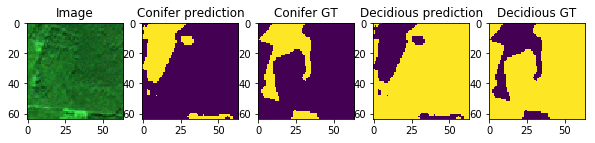

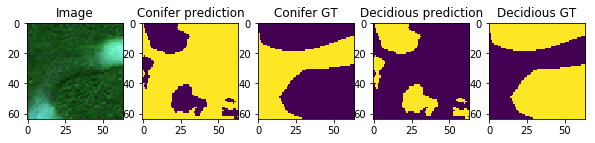

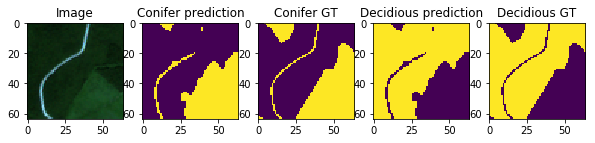

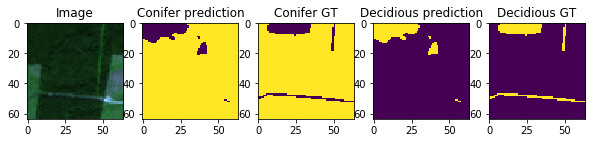

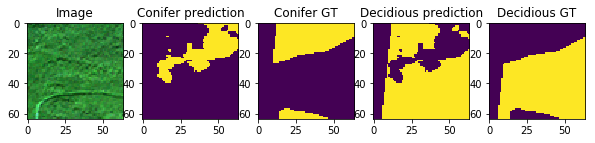

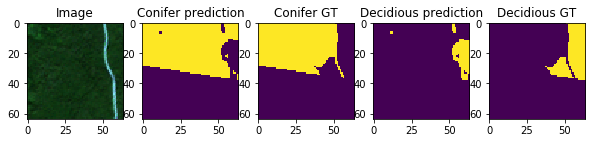

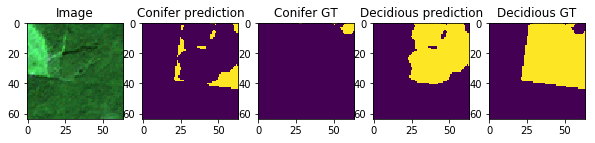

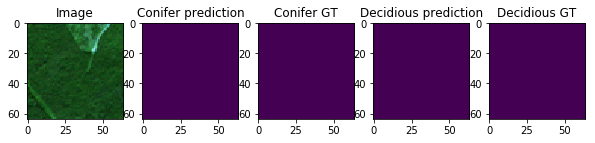

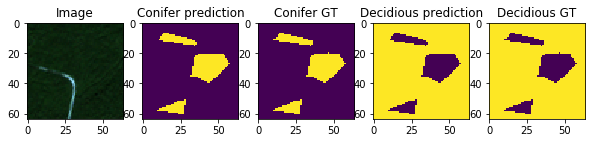

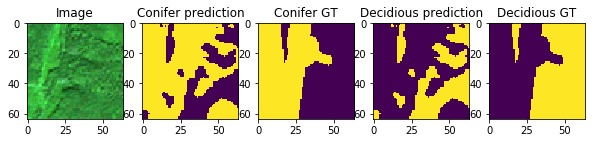

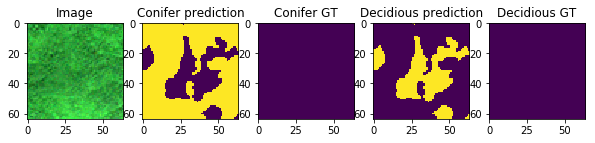

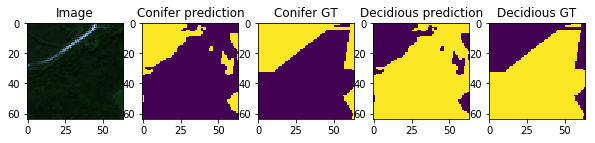

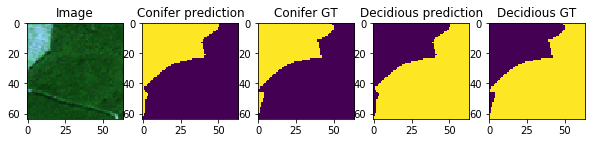

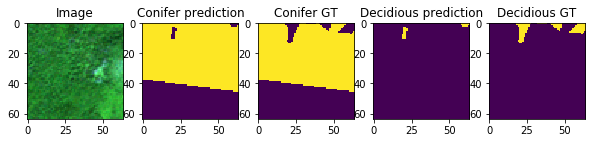

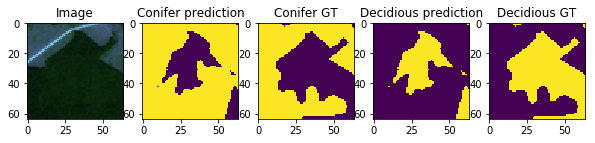

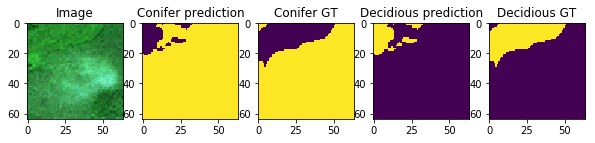

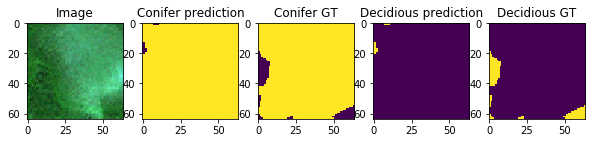

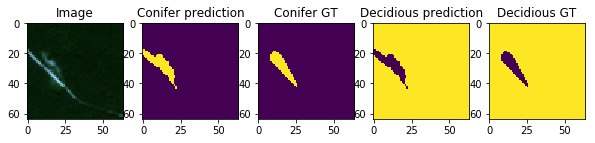

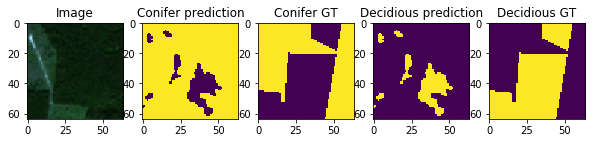

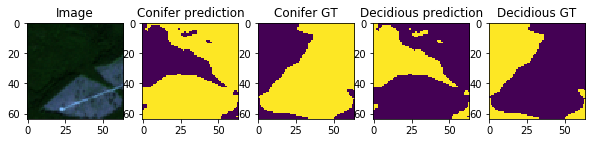

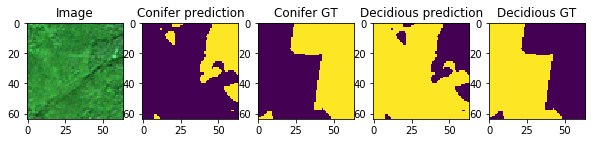

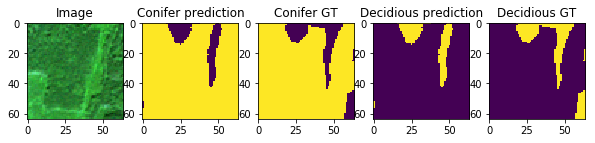

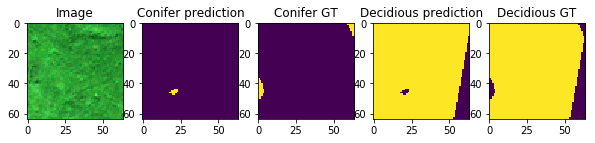

In [19]:
for num in range(1, 25):
    fig = plt.figure(figsize=(10, 10))
    a = fig.add_subplot(1, 5, 1)
    a.set_title('Image')
    imgplot = plt.imshow((img[num, :, :, 0:3] - np.min(img[num, :, :, 0:3]))/(np.max(img[num, :, :, 0:3]) 
                                                                           - np.min(img[num, :, :, 0:3])) )
    a = fig.add_subplot(1, 5, 2)
    a.set_title('Conifer prediction')
    imgplot = plt.imshow(np.where(np.argmax(pred[num,:,:,:], axis=2)==0, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 5, 3)
    a.set_title('Conifer GT')
    imgplot = plt.imshow(mask[num,:,:,0])
    a = fig.add_subplot(1, 5, 4)
    a.set_title('Decidious prediction')
    imgplot = plt.imshow(np.where(np.argmax(pred[num,:,:,:], axis=2)==1, 1, 0)*np.where(np.sum(mask[num,:,:,:], axis=2)>0, 1, 0)) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 5, 5)
    a.set_title('Decidious GT')
    imgplot = plt.imshow(mask[num,:,:,1])

In [161]:
def get_img_mask_array_val(imgpath, num_channels=10, num_classes=2, age_flag = False):
    class_0=['Oak']
    class_1=['Linden']
    with rasterio.open(imgpath+'/'+'B02.tif') as src:
        size_x = src.width
        size_y = src.height

    mask_0 = np.zeros((1, size_y, size_x))
    for cl_name in class_0:
        if '{}.tif'.format(cl_name) in os.listdir(imgpath):
            with rasterio.open(imgpath + '/{}.tif'.format(cl_name)) as src:
                mask_0 += src.read(1).astype(np.float)

    mask_1 = np.zeros((1, size_y, size_x))
    for cl_name in class_1:
        if '{}.tif'.format(cl_name) in os.listdir(imgpath):
            with rasterio.open(imgpath + '/{}.tif'.format(cl_name)) as src:
                mask_1 += src.read(1).astype(np.float)
    mask_1 = mask_1 > 0.5

    img = np.ones((size_y, size_x, num_channels), dtype=np.float)
    for i, ch in enumerate(['B02','B03','B04','B05','B06','B07','B08','B11','B12','B8A']):
        with rasterio.open(imgpath+'/'+ch+ '.tif') as src:
            img[:,:,i] = src.read(1)

    img /= 16000.
    img = img.clip(0, 1)

    mask = np.ones((size_y, size_x, num_classes)) 
    mask[:,:,0] = mask_0  
    mask[:,:,1] = mask_1 

    return np.asarray(img), np.asarray(mask)  
